In [1]:
from function_bank import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 20
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
class tabletDataset:
    def __init__(self, data, name, dep_var):
        self.name = name
        self.cp40 = data[data['CP']==40]
        self.y = self.cp40[dep_var]
        self.x = 'Not configured'
        self.train_x = 'Not configured'
        self.train_y = 'Not configured'
        self.val_x = 'Not configured'
        self.val_y = 'Not configured'
        self.valtrain_x = 'Not configured'
        self.valtrain_y = 'Not configured'
        self.test_x = 'Not configured'
        self.test_y = 'Not configured'
    
    
    def prepare_independent_vars(self, relevant_vars, categorical_vars):
        self.x = self.cp40[relevant_vars]
        
        def cat_var_to_onehot_encoded(df, col):
            series = df[col]
            one_hot = pd.get_dummies(series)
            df = pd.concat([df, one_hot], axis=1)
            df = df.drop(col, axis = 1)
            return df
        
        if len(categorical_vars) > 0:
            for i in categorical_vars:
                self.x = cat_var_to_onehot_encoded(self.x, i)
            print(self.name + ": Independent variables indentified, categorical variables one-hot encoded.")
                
        else:
            print(self.name + ": Independent variables indentified, no categorical variables to encode.")
            
            
#     def prepare_train_test(self):
#         self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(
#             self.x, self.y, test_size=0.1, random_state=1)
        
#     def prepare_train_test(self):
#         self.train_x, val_test_x, self.train_y, val_test_y = train_test_split(
#             self.x, self.y, test_size=0.2, random_state=1)
        
#         self.val_x, self.test_x, self.val_y, self.test_y = train_test_split(
#             val_test_x, val_test_y, test_size=0.5, random_state=1)
    def prepare_train_test(self):
        self.train_x, val_test_x, self.train_y, val_test_y = train_test_split(self.x, self.y, 
                                                                              test_size=0.2, random_state=1)
        
        self.val_x, self.test_x, self.val_y, self.test_y = train_test_split(val_test_x, val_test_y, 
                                                                            test_size=0.5, random_state=1)
        
        self.valtrain_x = pd.concat([self.train_x, self.val_x])
        self.valtrain_y = pd.concat([self.train_y, self.val_y])

In [3]:
def build_regression_trees(tablet_dataset):
    build_results = []
    for i in tqdm(range(1, 11)):
        regression = DecisionTreeRegressor(random_state=1, max_depth=i)
        regression.fit(tablet_dataset.train_x, tablet_dataset.train_y)
        train_los = mean_squared_error(tablet_dataset.train_y, regression.predict(tablet_dataset.train_x))
        val_los = mean_squared_error(tablet_dataset.val_y, regression.predict(tablet_dataset.val_x))
        
        build_results.append([i, train_los, val_los])
    print(build_results)
    return build_results


def plot_prep(build_results):
    min_val_mse = [0, float('inf')]
    train_mse = []
    val_mse = []

    for i in build_results:
        train_mse.append(i[1])
        val_mse.append(i[2])
        if i[2] < min_val_mse[1]:
            min_val_mse = [i[0], i[2]]
    print(min_val_mse, train_mse, val_mse)
    return min_val_mse, train_mse, val_mse


def make_graph(train_mse, val_mse, min_val_mse, tabletDataset):
    plt.plot(range(1, 11), train_mse, 'r--', label='Training')
    plt.plot(range(1, 11), val_mse, 'b--', label='Validation')
    plt.plot(min_val_mse[0], min_val_mse[1], 'bo')
    plt.title(tabletDataset.name + ': Max Depth Vs. MSE to Predict E')
    plt.xlabel('Max Depth of Decision Tree')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig(tabletDataset.name + '_graph_E.png')
    plt.show()
    

def make_tree(min_mse, tabletDataset):
    
    final_regression = DecisionTreeRegressor(random_state=42, max_depth=min_mse[0])
    final_regression.fit(tabletDataset.x, tabletDataset.y)
    plt.figure(figsize=(25, 20))  # Hard coded for my screen
    plot_tree(final_regression, feature_names=tabletDataset.x.columns, fontsize=10, proportion=True)
    plt.savefig(tabletDataset.name + '_tree.png')
    plt.show()


In [4]:
spim_data = pd.read_csv('/Users/quintonaguilera/Desktop/Aederide & Toledo/capsule_research/Nov15_V3Data/SPIM.xlsx - Sheet1.csv',
                   delimiter=",")

mups_data = pd.read_csv('/Users/quintonaguilera/Desktop/Aederide & Toledo/capsule_research/Nov15_V3Data/MUPS.xlsx - Sheet1.csv',
                   delimiter=",")

relevant_vars = ['Excipient', 'Pellet', 'Span', 'MPS', 'HR', 'Y']
categorical_vars = ['Excipient', 'Pellet']

spim = tabletDataset(spim_data, 'SPIM', 'E')
mups = tabletDataset(mups_data, 'MUPS', 'E')

datasets = [spim, mups]

In [5]:
spim.prepare_independent_vars(relevant_vars, categorical_vars)
spim.prepare_train_test()
mups.prepare_independent_vars(relevant_vars, categorical_vars)
mups.prepare_train_test()

print('SPIM Oberservations: ', len(spim.y))
print('MUPS Oberservations: ', len(mups.y))


SPIM: Independent variables indentified, categorical variables one-hot encoded.
MUPS: Independent variables indentified, categorical variables one-hot encoded.
SPIM Oberservations:  42
MUPS Oberservations:  48


<h2>Linear Regression (Baseline)</h2>

In [6]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(spim.train_x, spim.train_y)
spim_lin_mse = mean_squared_error(spim.test_y, reg.predict(spim.test_x))
print('SPIM MSE: ', spim_lin_mse)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(mups.train_x, mups.train_y)
mups_lin_mse = mean_squared_error(mups.test_y, reg.predict(mups.test_x))
print('MUPS MSE: ', mups_lin_mse)

SPIM MSE:  10.25324292748503
MUPS MSE:  78.43864206980291


<h2>CART</h2>

In [7]:
spim_results = build_regression_trees(spim)
mups_results = build_regression_trees(mups)

100%|██████████| 10/10 [00:00<00:00, 182.01it/s]


[[1, 17.794296161616163, 12.802348111111124], [2, 15.400979329004329, 9.83789695649093], [3, 9.591095353535353, 4.641286805555555], [4, 8.608244343434341, 4.488745138888888], [5, 8.608244343434341, 4.488745138888888], [6, 8.608244343434341, 4.488745138888888], [7, 8.608244343434341, 4.488745138888888], [8, 8.608244343434341, 4.488745138888888], [9, 8.608244343434341, 4.488745138888888], [10, 8.608244343434341, 4.488745138888888]]


100%|██████████| 10/10 [00:00<00:00, 172.79it/s]

[[1, 39.122234903047094, 33.864595124653725], [2, 22.625476616541352, 56.95047817777775], [3, 19.663689844804317, 69.09368080539113], [4, 18.620339912280702, 67.2385077777778], [5, 18.532755701754382, 68.28627444444444], [6, 18.523911842105257, 68.82445444444444], [7, 18.523911842105257, 68.82445444444444], [8, 18.523911842105257, 68.82445444444444], [9, 18.523911842105257, 68.82445444444444], [10, 18.523911842105257, 68.82445444444444]]


In [8]:
spim_min_val_mse, spim_train_mse, spim_val_mse = plot_prep(spim_results)
print()
mups_min_val_mse, mups_train_mse, mups_val_mse = plot_prep(mups_results)

[4, 4.488745138888888] [17.794296161616163, 15.400979329004329, 9.591095353535353, 8.608244343434341, 8.608244343434341, 8.608244343434341, 8.608244343434341, 8.608244343434341, 8.608244343434341, 8.608244343434341] [12.802348111111124, 9.83789695649093, 4.641286805555555, 4.488745138888888, 4.488745138888888, 4.488745138888888, 4.488745138888888, 4.488745138888888, 4.488745138888888, 4.488745138888888]

[1, 33.864595124653725] [39.122234903047094, 22.625476616541352, 19.663689844804317, 18.620339912280702, 18.532755701754382, 18.523911842105257, 18.523911842105257, 18.523911842105257, 18.523911842105257, 18.523911842105257] [33.864595124653725, 56.95047817777775, 69.09368080539113, 67.2385077777778, 68.28627444444444, 68.82445444444444, 68.82445444444444, 68.82445444444444, 68.82445444444444, 68.82445444444444]


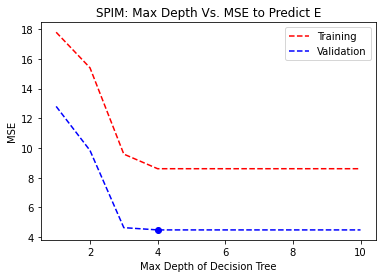

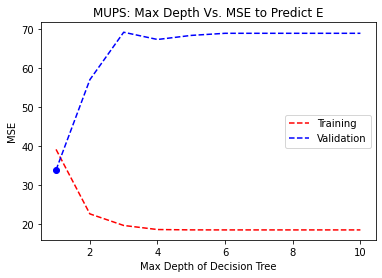

In [9]:
make_graph(spim_train_mse, spim_val_mse, spim_min_val_mse, spim)
make_graph(mups_train_mse, mups_val_mse, mups_min_val_mse, mups)

In [10]:
final_regression = DecisionTreeRegressor(random_state=1, max_depth=4)
final_regression.fit(spim.train_x, spim.train_y)
mse = mean_squared_error(spim.val_y, final_regression.predict(spim.val_x))
print(mse)

4.488745138888888


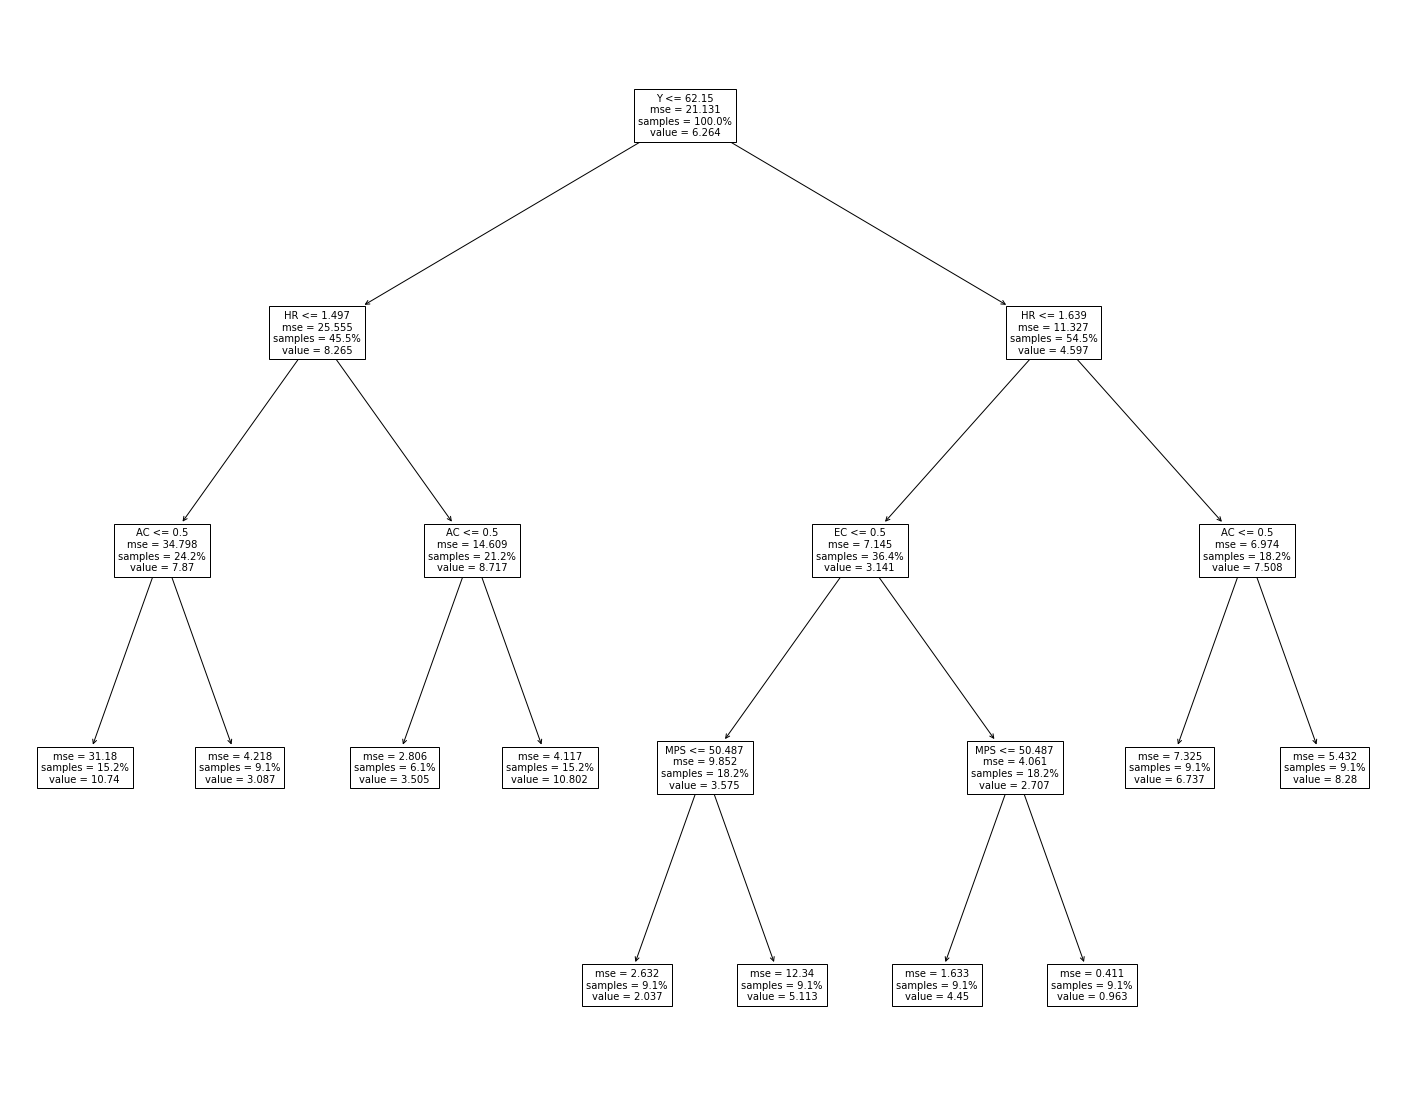

In [11]:
plt.figure(figsize=(25, 20))  # Hard coded for my screen
plot_tree(final_regression, feature_names=spim.x.columns, fontsize=10, proportion=True)
plt.savefig(spim.name + '_tree_E.png')
plt.show()

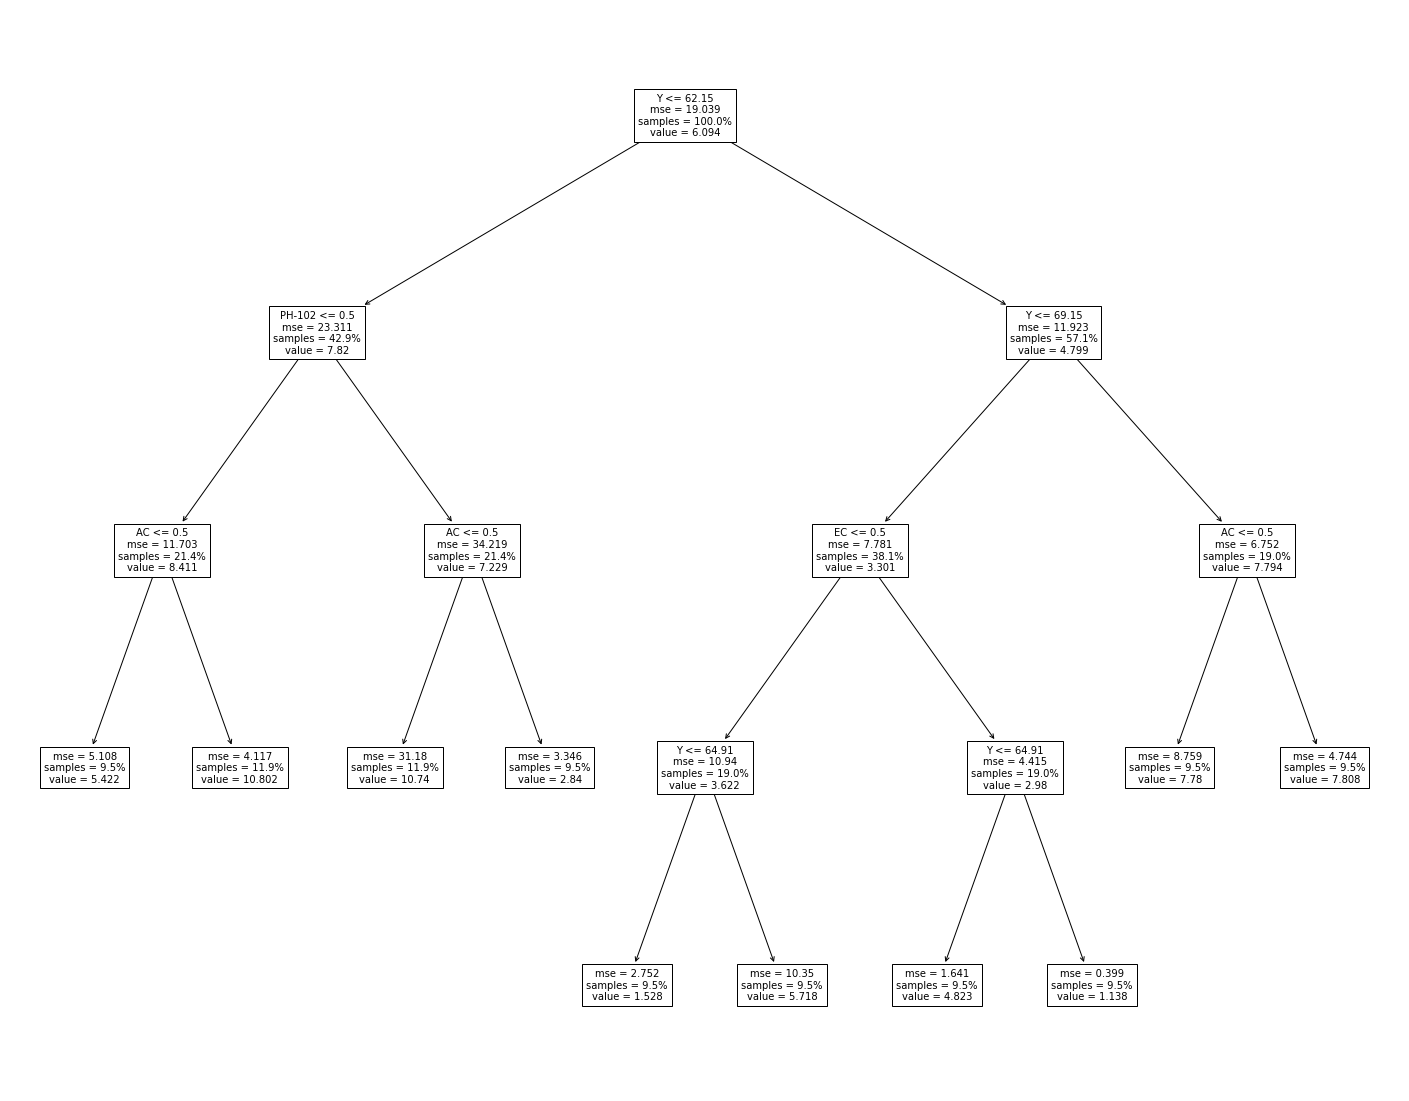

In [12]:
make_tree(spim_min_val_mse, spim)
# make_tree(mups_min_val_mse, mups)

In [13]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_regression, feature_names=spim40_x.columns, filled=True)


NameError: name 'tree' is not defined

<Figure size 1800x1440 with 0 Axes>

In [14]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(final_regression, spim40_x, spim40_y,
                target_name="E",
                feature_names=spim40_x.columns)
viz


NameError: name 'spim40_x' is not defined